# On-line NIR analysis in a high density polyethene plant

Re-evaluating the NIR data used in my M.Sc.(eng.) thesis.

> Mathisen, R. (1999). On-line NIR analysis in a high density polyethene plant, evaluation of sampling system and optimal calibration strategy. Telemark College, Department of Technology.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter

In [2]:
all_df = pd.read_csv('bronir2-all.TXT', sep=',', na_values = ['m'])
all_df.info()
all_df.head()
#all_df[all_df.Dens > 900] # All data with valid density measurements

<class 'pandas.core.frame.DataFrame'>
Index: 880 entries, 980713-2:20 to 990108-2:421
Columns: 1208 entries, Product to 2500.0
dtypes: float64(1208)
memory usage: 8.1+ MB


,Product,Catalyst,Dens,Mfr190/2,Mfr190/5,Mfr190/21,Temp,1300.0,1301.0,1302.0,...,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0
980713-2:20,8.0,0.0,936.099976,NaN,0.97,14.1,NaN,0.001753,0.001767,0.001800,...,0.263289,0.276664,0.292457,0.312405,0.336896,0.367879,0.405578,0.451296,0.506242,0.571901
980713-2:64,8.0,0.0,938.900024,NaN,0.84,11.9,NaN,-0.007259,-0.007261,-0.007240,...,0.326356,0.343830,0.363631,0.388610,0.420130,0.461255,0.511990,0.575668,0.651195,0.739630
980713-2:92,8.0,0.0,NaN,NaN,NaN,12.3,NaN,0.072211,0.072389,0.072569,...,0.262145,0.274324,0.288954,0.307731,0.329331,0.353835,0.379205,0.405775,0.431037,0.456781
980713-2:116,8.0,0.0,938.599976,NaN,NaN,11.4,NaN,0.008682,0.008683,0.008708,...,0.383956,0.411971,0.446242,0.489790,0.544611,0.613561,0.697944,0.801592,0.923604,1.065754
980713-2:165,8.0,0.0,938.299988,NaN,0.87,14.0,NaN,0.016686,0.016687,0.016707,...,0.433395,0.461214,0.495580,0.537592,0.592171,0.659849,0.746200,0.851635,0.981991,1.136913


In [107]:
wl_start = 1300 # Starts at column index 7 in the dataframe
wl_end = 2120   # Very noisy data above 2120 nm
X = all_df.values[:,7:(wl_end-wl_start+7)].astype('float32') # NIR spectrum
Xmean = np.mean(X, axis=0)                   # Mean spectrum (all data)
dens = all_df.values[:,2].astype('float32')  # measured density from lab
prod = all_df.values[:,0].astype('int32')    # Product type
cat = all_df.values[:,1].astype('int32')     # Catalyst type
wl = range(wl_start, wl_end)                 # NIR wavelength range


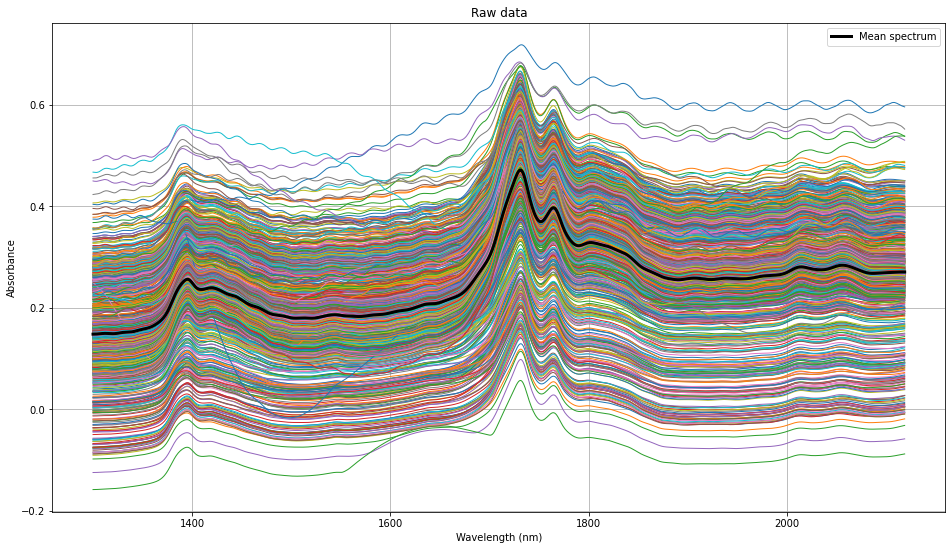

In [108]:
plt.figure(figsize=[16, 9])
for n in range(0, len(X)):
    plt.plot(wl, X[n], linewidth=1)
plt.plot(wl, Xmean, color="black", linewidth=3, label="Mean spectrum")
plt.title('Raw data')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.grid()
plt.legend()
plt.show()

Standard Normal Variate (SNV) method performs a normalization of the spectra that consists in subtracting each spectrum by its own mean and dividing it by its own standard deviation. After SNV, each spectrum will have a mean of 0 and a standard deviation of 1.

SNV attempts at making all spectra comparable in terms of intensities (or absorbance level). It can be useful to correct spectra for changes in optical path length and light scattering (it is assumed that the standard deviation of the spectra represents well these changes). 

SNV will be used in preprocessing of the NIR data here. Defining a SVN function:

In [26]:
def snv(X):
    '''Standard Normal Variate'''
    # Define a new array and populate it with the corrected data  
    Xsnv = np.zeros_like(X)
    Xmean = np.mean(X, axis=1)
    Xstd = np.std(X, axis=1)
    for i in range(X.shape[0]):
        Xsnv[i,:] = (X[i,:] - Xmean[i]) / Xstd[i]
 
    return Xsnv

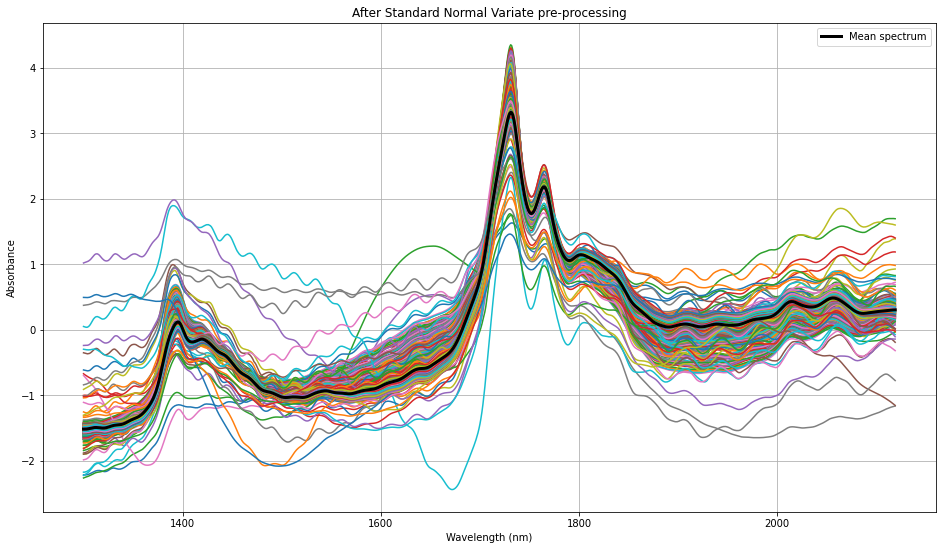

In [111]:
Xsnv = snv(X)
Xsvnmean = np.mean(Xsnv, axis=0)                   # Mean spectrum (all data)
plt.figure(figsize=[16, 9])
for n in range(0, len(Xsnv)):
    plt.plot(wl, Xsnv[n])
plt.plot(wl, Xsvnmean, color="black", linewidth=3, label="Mean spectrum")
plt.title('After Standard Normal Variate pre-processing')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.grid()
plt.legend()
plt.show()

**TODO**
Locate and remove outlier spectra

In [23]:
# TODO


In [24]:
# Second derivative
Xpre = savgol_filter(Xsnv, 25, polyorder = 2, deriv=2, mode='mirror')


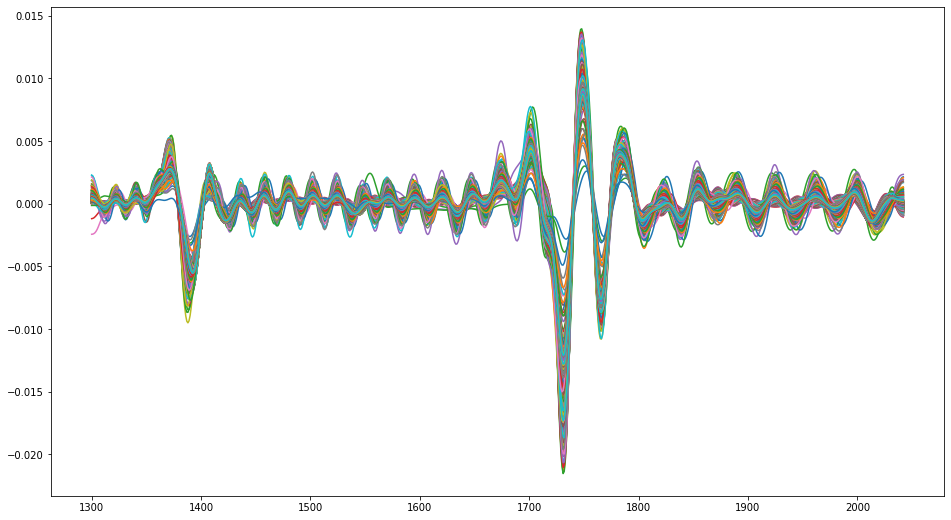

In [25]:
plt.figure(figsize=[16, 9])
for n in range(0, len(Xpre)):
    plt.plot(wl, Xpre[n])
plt.show()

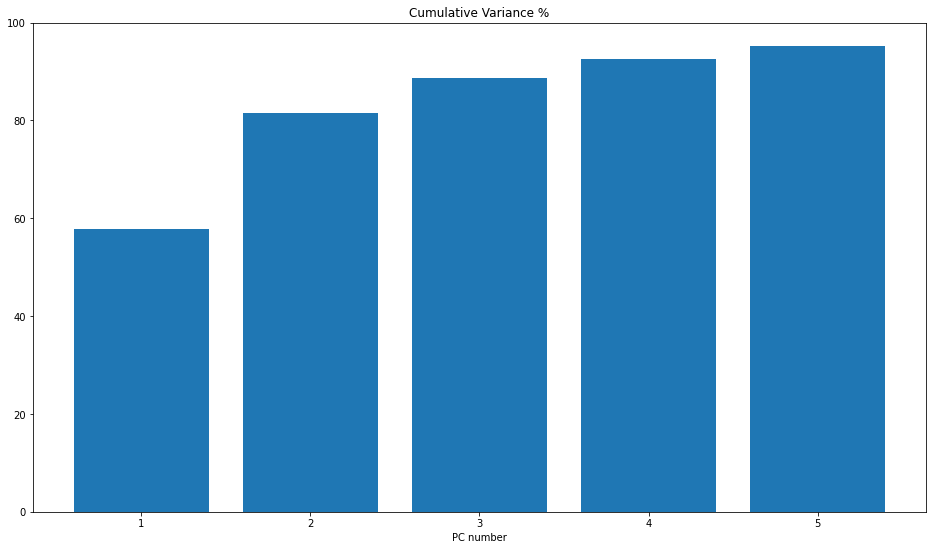

In [26]:
# https://nirpyresearch.com/nir-data-correlograms-seaborn-python/
pca = PCA(n_components=5)
# Fit the model with X and apply the dimensionality reduction on X.
Xpca = pca.fit_transform(Xpre)

plt.figure(figsize=[16, 9])
#plt.plot(np.cumsum(pca.explained_variance_ratio_)*100,'-o')
plt.bar([1, 2, 3, 4, 5], np.cumsum(pca.explained_variance_ratio_)*100)
plt.title("Cumulative Variance %")
plt.xlabel("PC number")
plt.show()

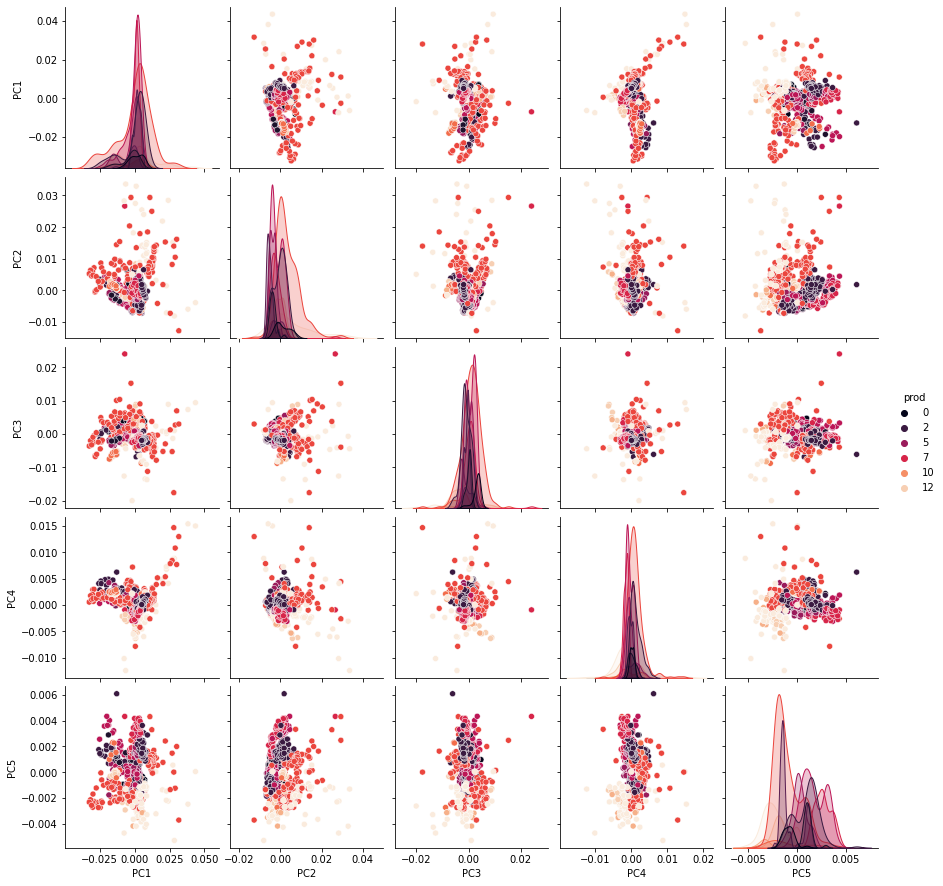

In [27]:
Xpca_df = pd.DataFrame(Xpca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
Xpca_df['prod'] = prod
sns.pairplot(Xpca_df, hue='prod', palette='rocket')
plt.show()

<AxesSubplot:>

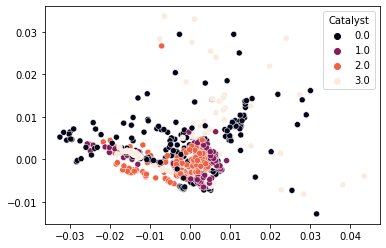

In [32]:
sns.scatterplot(x=Xpca_df.PC1.values, y=Xpca_df.PC2.values, hue=all_df.Catalyst, palette='rocket')

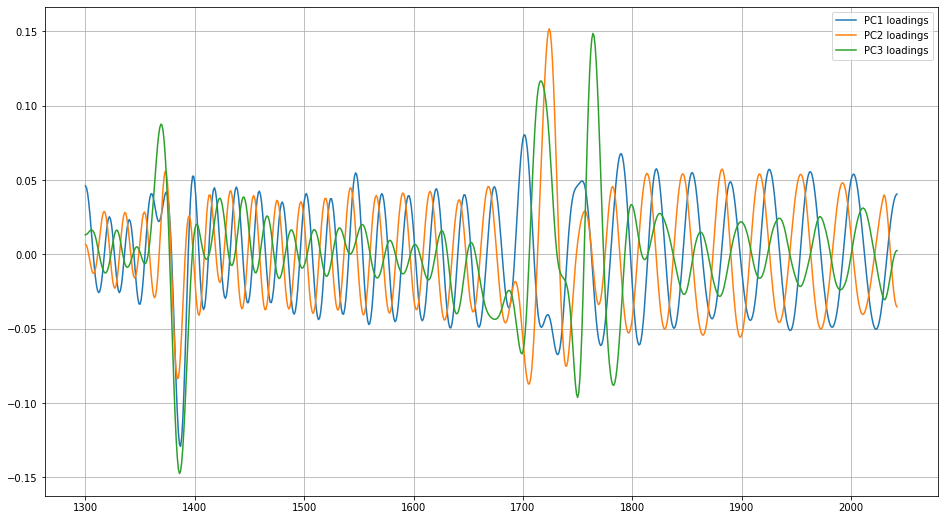

In [29]:
plt.figure(figsize=[16, 9])
plt.plot(wl, pca.components_.T[:,1], label="PC1 loadings")
plt.plot(wl, pca.components_.T[:,2], label="PC2 loadings")
plt.plot(wl, pca.components_.T[:,3], label="PC3 loadings")
plt.grid()
plt.legend()
plt.show()